##### Copyright 2019 The TensorFlow Authors.

**@title Licensed under the Apache License, Version 2.0 (the "License");**
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.




**@title MIT License**
 Copyright (c) 2017 François Chollet
 Permission is hereby granted, free of charge, to any person obtaining a
 copy of this software and associated documentation files (the "Software"),
 to deal in the Software without restriction, including without limitation
 the rights to use, copy, modify, merge, publish, distribute, sublicense,
 and/or sell copies of the Software, and to permit persons to whom the
 Software is furnished to do so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in
 all copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
 THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
 FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
 DEALINGS IN THE SOFTWARE.

# Basic text classification

This notebook demonstrates text classification starting from plain text files stored on disk.The output will be a trained binary classifier ready to perform HTTP body and URI malicious recognition.

In [88]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.19.0


In [89]:
dataset_name = 'LeTest'
model_name = 'CNN1D'

In [90]:
pos_n = 30
dataset_dir = '../datasets/' + dataset_name
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)
sample_file = os.path.join(train_dir, f"benin/{pos_n}.txt")
with open(sample_file) as f:
  print(f"le contenue du {pos_n} ème donnée positive du dataset : {f.read()}")


le contenue du 30 ème donnée positive du dataset : regueras de arriba


### Load the dataset

Next, we load the data off disk and prepare it into a format suitable for training. To do so, we levrage the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility.

To prepare a dataset with this utility, for binary classification, we need two folders on disk, corresponding to `class_a` and `class_b`. These will be the benin and malicious http requests, which can be found in `LeTest/train/pos` and `LeTest/train/neg`.

Next we load the dataset as a `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data)

In [91]:
batch_size = 32
seed = 52705209

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 21746 files belonging to 2 classes.
Using 17397 files for training.


We will use 80% of the training dataset purely for training and 20% of it for validation. In the end the dataset is splited like so, 60% for training, 20% for validation and 20% for testing. 


In [92]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'45571518p'
Label 0
Review b"1' in boolean mode) or (select * from (select(sleep(5)))sddo)#"
Label 1
Review b'iznate'
Label 0


The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [93]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to benin
Label 1 corresponds to malicious


Note:  When using the `validation_split` and `subset` arguments, we need to make sure  either a random seed is specified, or `shuffle=False` is passed, so that the validation and training splits have no overlap.

In [94]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 21746 files belonging to 2 classes.
Using 4349 files for validation.


In [95]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size)

Found 21746 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [96]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [97]:
max_features = 100000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    # standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [98]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2025-08-26 00:07:44.714331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's create a function to see the result of using this layer to preprocess some data.

In [99]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [100]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'pro8i2ic6r', shape=(), dtype=string)
Label benin
Vectorized review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[4817,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [101]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  linares
 313 --->  1iif52575257110
Vocabulary size: 19569


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [102]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [103]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model architecture

In [104]:
embedding_dim = 16

In [105]:
#default
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

# #cnn
# model = tf.keras.Sequential([
# layers.Embedding(max_features, embedding_dim, input_length=sequence_length),
# layers.SpatialDropout1D(0.2),
# layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='valid'),
# layers.GlobalMaxPooling1D(),
# layers.Dropout(0.2),
# layers.Dense(1, activation='sigmoid')
# ])

# #lstm
# model = tf.keras.Sequential([
#   layers.Embedding(max_features, embedding_dim, input_length=sequence_length),
#   layers.SpatialDropout1D(0.2),
#   layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.0)),
#   layers.Dropout(0.2),
#   layers.Dense(1, activation='sigmoid')
# ])


### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use `losses.BinaryCrossentropy` loss function.

In [118]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, None, 16)       │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,017 (6.10 MB)

 Trainable params: 1,600,017 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [121]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.9700 - loss: 0.1063 - val_binary_accuracy: 0.9795 - val_loss: 0.1009
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.9719 - loss: 0.1032 - val_binary_accuracy: 0.9795 - val_loss: 0.0964
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.9723 - loss: 0.0994 - val_binary_accuracy: 0.9795 - val_loss: 0.0975
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.9722 - loss: 0.0984 - val_binary_accuracy: 0.9795 - val_loss: 0.0895
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.9742 - loss: 0.0957 - val_binary_accuracy: 0.9795 - val_loss: 0.0984
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9748 - loss: 0.0932 - val_binary_accuracy: 0.9795 - val_loss: 0.0889
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.9760 - loss: 0.0931 - val_binary_accuracy: 0.9795 - val_loss: 0.0865
Epoch 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [108]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - binary_accuracy: 0.9601 - loss: 0.1710
Loss:  0.1707019954919815
Accuracy:  0.9596707224845886


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [109]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

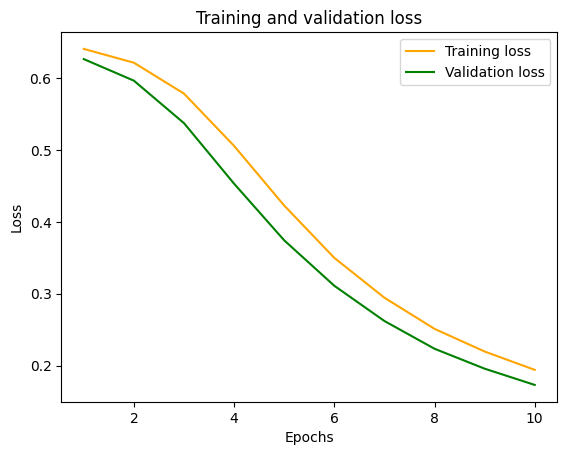

In [110]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'orange', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 0.25) 
plt.show()

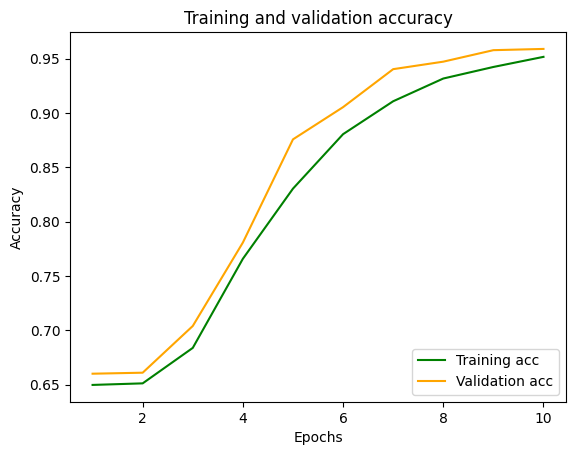

In [111]:
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [112]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
])

export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - binary_accuracy: 0.9601 - loss: 0.1710
{'binary_accuracy': 0.9596707224845886, 'loss': 0.17070211470127106}


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [125]:
examples = tf.constant([
  "pouet",
  " 1 OR 1==1--",
  "${${::-j}${::-n}${::-d}${::-i}:${::-l}${::-d}${::-a}${::-p}:"
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.10966771],
       [0.99871975],
       [0.10966771]], dtype=float32)

The text prepocessing is now included in the model, this enables to export the a model for production.

In [114]:
export_archive = tf.keras.export.ExportArchive()
export_archive.track(model)
export_archive.add_endpoint(
    name='serve',
    fn=model.call,
    input_signature=[tf.TensorSpec(shape=(1, sequence_length), dtype=tf.int32)],
)
export_archive.write_out('../trained-models/temp/')

converter = tf.lite.TFLiteConverter.from_saved_model('../trained-models/temp/')

classifier_model = converter.convert()

with open('../trained-models/'+ model_name + '.model', 'wb') as f:
    f.write(classifier_model)


INFO:tensorflow:Assets written to: ../trained-models/temp/assets


INFO:tensorflow:Assets written to: ../trained-models/temp/assets


Saved artifact at '../trained-models/temp/'. The following endpoints are available:

* Endpoint 'serve'
  inputs (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 300), dtype=tf.int32, name=None)
  training (POSITIONAL_OR_KEYWORD): Literal[None]
  mask (POSITIONAL_OR_KEYWORD): Literal[None]
Output Type:
  TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
Captures:
  139929301265744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139929301270160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139929301265360: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1756159706.037591  822124 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756159706.037614  822124 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-26 00:08:26.037781: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../trained-models/temp/
2025-08-26 00:08:26.038152: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-26 00:08:26.038158: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: ../trained-models/temp/
2025-08-26 00:08:26.040908: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-26 00:08:26.075077: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: ../trained-models/temp/
2025-08-26 00:08:26.081117: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 43340 microseconds.
2025-08-26 00:08:26.1761

In [115]:
source = '../trained-models/'+ model_name+'.model'

destination = '../../lab/snort/host-volume/'+model_name+'.model'
shutil.copy(source, destination)

shutil.rmtree('../trained-models/temp')